# Distributed probability map

This notebook contains a prototype for the impact map, taking as example the water risk calculation.

water impacts are deffined as:

    Water impact  (m3 / year ) = (water footprint (m3/year) / production (tons)) * (production (tons) / Total Production (tons)) * Volume (tons)

    Water impact (m3 / year) = Water use per ton * distribution of crop production * tons

Equal to:
    
    Water impact  (m3 / year ) = water footprint (m3/year) * Volume (tons) / Total Production (tons)

    Water impact (m3 / year) = Water use due to the crop * percent of production you are responsible for


The volume is distributed using the 'probabilistics purchase area' approach:

    F’ = (V / TotalHarvestSrea) * (Harvest area)
    F’ = (Tons / Hectares (total)) * (Hectares)
            ^ same for the whole raster       ^ per cell



NOTE: https://www.postgresql.org/docs/current/sql-createfunction.html

In [2]:
#import libraries
from psycopg2.pool import ThreadedConnectionPool
import rasterio as rio
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import json
import h3
from shapely.geometry import Polygon
import geopandas as gpd

from IPython.display import Image

In [3]:
## env file for gcs upload
env_path = ".env"
with open(env_path) as f:
    env = {}
    for line in f:
        env_key, _val = line.split("=", 1)
        env_value = _val.split("\n")[0]
        env[env_key] = env_value
        
list(env.keys())

['API_SERVICE_PORT',
 'API_POSTGRES_HOST',
 'API_POSTGRES_PORT',
 'API_POSTGRES_USERNAME',
 'API_POSTGRES_PASSWORD',
 'API_POSTGRES_DATABASE',
 'CLIENT_SERVICE_PORT']

In [4]:
# conect to ddbb
postgres_thread_pool = ThreadedConnectionPool(1, 50,
                                              host=env['API_POSTGRES_HOST'],
                                              port=env['API_POSTGRES_PORT'],
                                              user=env['API_POSTGRES_USERNAME'],
                                              password=env['API_POSTGRES_PASSWORD']
                                              )


## Check distribution map in a test location:

In [18]:
sql = """select  t1.k, (t1.tonnage/sum(t2.ha) over())*t2.ha*t2.wrcotton as waterimpact from
	(select sr.tonnage, h3_uncompact(gr."h3Compact"::h3index[],6) as k from sourcing_records sr 
	left  join sourcing_location sl on sl.id = sr."sourcingLocationId" 
	left join geo_region gr on gr.id = sl."geoRegionId" 
	where sr.id='4057312f-131b-44a3-86cb-4ff6253026ce') t1
inner join 
	(select prodtable.h3index as k, indtable."wfBltotMmyr" * 0.001 / sum(prodtable."earthstat2000GlobalRubberProduction") over() as wrcotton,
	hatable."earthstat2000GlobalRubberHarvestedareahectares"  as ha
	from h3_grid_earthstat2000_global_prod prodtable
	inner join h3_grid_wf_global indtable on indtable.h3index = prodtable.h3index
	inner join h3_grid_earthstat2000_global_ha hatable on hatable.h3index =prodtable.h3index 
	where prodtable."earthstat2000GlobalRubberProduction" is not null and indtable."wfBltotMmyr" is not null 
	and hatable."earthstat2000GlobalRubberHarvestedareahectares"  is not null) t2
on t1.k=t2.k"""

conn = postgres_thread_pool.getconn()
cursor = conn.cursor()
cursor.execute(sql)
#fetch data
response = cursor.fetchall()


In [19]:
len(response)

115

In [20]:
len(set([el[0] for el in response]))

115

In [22]:
# parse the response to json so we can explore results in keppler:

clean_response = []
for el in tqdm(response):
    clean_response.append({
        'hexId':el[0],
        'value': el[1]*1000000000
    })
    
print(len(clean_response))

  0%|          | 0/115 [00:00<?, ?it/s]

115


In [23]:
#export to json

# export json and explore in keppler
with open('./distribited_impact_test_location.json', 'w') as f:
    json.dump(clean_response, f)

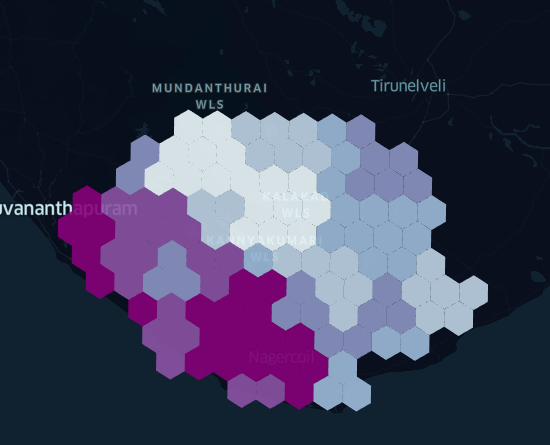

In [25]:
# image showing imports of rubber to chinna
Image(filename = "../../datasets/raw/water_impact_test_location.png")

## Check distribution map in a india:

Check distribution on impact in india - for the same location we have tested in the notebook: QA_risk:impact_calc_blwf

#### Build the query by parts so we can test different outputs:

    
### 1. Calculate water risk
    Water impact  (m3 / year ) = water footprint (m3/year) / Total Production (tons)

In [77]:
## get total production of cotton in india base on h3
sql = """select t1.k, t2.prod from
	(select sr.tonnage, h3_uncompact(gr."h3Compact"::h3index[],6) as k from sourcing_records sr 
	left  join sourcing_location sl on sl.id = sr."sourcingLocationId" 
	left join geo_region gr on gr.id = sl."geoRegionId" 
	where gr."name" = 'IND'
	and sr.tonnage = 745) t1
inner join
	(select prodtable.h3index as k, prodtable."spam2010V2R0GlobalPCottA" as prod  from h3_grid_spam2010v2r0_global_prod prodtable) t2
on t1.k = t2.k
"""
conn = postgres_thread_pool.getconn()
cursor = conn.cursor()
cursor.execute(sql)
#fetch data
response = cursor.fetchall()

In [78]:
clean_response = []
for el in tqdm(response):
    clean_response.append({
        'hexId':el[0],
        'value': el[1],
        #'geom': Polygon(h3.h3_to_geo_boundary(el[0]))
    })
    
print(len(clean_response))

## export json and explore in keppler
#with open('./prod_cotton_test_h3_geom.json', 'w') as f:
#    json.dump(clean_response, f)

  0%|          | 0/80268 [00:00<?, ?it/s]

80268


In [80]:
#gdf = gpd.GeoDataFrame(clean_response,geometry = 'geom', crs='EPSG:4326')
#gdf.head()

,hexId,value,geom
0,8642e261fffffff,1.0,"POLYGON ((23.38084 68.55656, 23.34992 68.56306..."
1,863c898c7ffffff,16.7,"POLYGON ((21.60674 88.35377, 21.64177 88.35572..."
2,86640bd67ffffff,0.0,"POLYGON ((10.67508 92.60262, 10.71176 92.60502..."
3,86640bd5fffffff,0.0,"POLYGON ((10.78916 92.54525, 10.82585 92.54764..."
4,86640bd6fffffff,0.0,"POLYGON ((10.67910 92.53808, 10.71579 92.54047..."


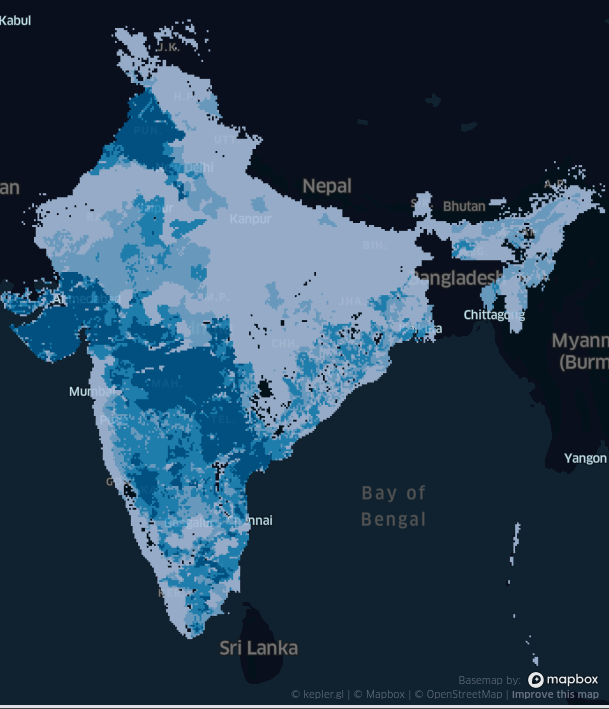

In [11]:
# image showing imports of rubber to chinna
Image(filename = "../../datasets/raw/prod_cotton_india_h3.png")

In [91]:
# get blue water footprint:

sql = """select t1.k, t2.ind as blwf from
	(select sr.tonnage, h3_uncompact(gr."h3Compact"::h3index[],6) as k from sourcing_records sr 
	left  join sourcing_location sl on sl.id = sr."sourcingLocationId" 
	left join geo_region gr on gr.id = sl."geoRegionId" 
	where gr."name" = 'IND'
	and sr.tonnage = 745) t1
inner join
	(select prodtable.h3index as k, prodtable."spam2010V2R0GlobalPCottA" as prod, indtable."wfBltotMmyr" as ind from h3_grid_spam2010v2r0_global_prod prodtable
	left join h3_grid_wf_global indtable on indtable.h3index= prodtable.h3index
	where indtable."wfBltotMmyr" > 0) t2
on t1.k = t2.k"""

conn = postgres_thread_pool.getconn()
cursor = conn.cursor()
cursor.execute(sql)
#fetch data
response = cursor.fetchall()

In [93]:
clean_response = []
for el in tqdm(response):
    clean_response.append({
        'hexId':el[0],
        'value': el[1],
        #'geom': Polygon(h3.h3_to_geo_boundary(el[0]))
    })
    
print(len(clean_response))

# export json and explore in keppler
with open('./blwf_ind_test_v2.json', 'w') as f:
    json.dump(clean_response, f)

  0%|          | 0/79558 [00:00<?, ?it/s]

79558


In [9]:
# calculate water risk for cotton in the entire world

sql = """select prodtable.h3index as k, indtable."wfBltotMmyr" * 0.001 / sum(prodtable."spam2010V2R0GlobalPCottA") over() as wrcotton 
from h3_grid_spam2010v2r0_global_prod prodtable
inner join h3_grid_wf_global indtable on indtable.h3index = prodtable.h3index 
where prodtable."spam2010V2R0GlobalPCottA" is not null and indtable."wfBltotMmyr" is not null"""

conn = postgres_thread_pool.getconn()
cursor = conn.cursor()
cursor.execute(sql)
#fetch data
response = cursor.fetchall()

In [10]:
clean_response = []
for el in tqdm(response):
    clean_response.append({
        'hexId':el[0],
        'value': el[1]*1000000000,
        #'geom': Polygon(h3.h3_to_geo_boundary(el[0]))
    })
    
print(len(clean_response))

# export json and explore in keppler
with open('./water_risk_cotton_worldwide_v4.json', 'w') as f:
    json.dump(clean_response, f)

  0%|          | 0/1591028 [00:00<?, ?it/s]

1591028


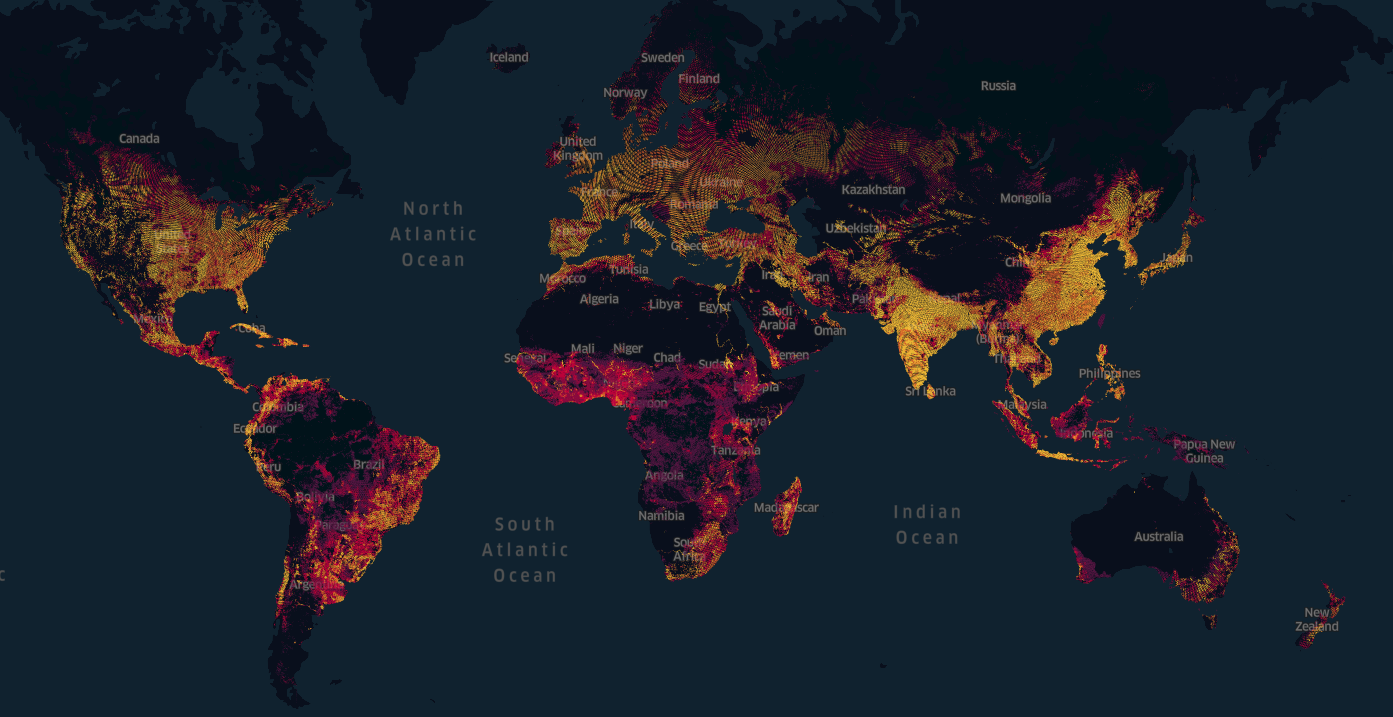

In [15]:

# image showing total water risk for cotton
Image(filename = "../../datasets/raw/water_risk_cotton.png")

In [12]:
# compute the  total water impact
sql = """select t1.k, (t1.tonnage/sum(t2.ha) over())*t2.ha*t2.wrcotton as waterimpact from
	(select sr.tonnage, h3_uncompact(gr."h3Compact"::h3index[],6) as k from sourcing_records sr 
		left  join sourcing_location sl on sl.id = sr."sourcingLocationId" 
		left join geo_region gr on gr.id = sl."geoRegionId" 
		where gr."name" = 'IND'
		and sr.tonnage = 745) t1
inner join
	(select prodtable.h3index as k, indtable."wfBltotMmyr" * 0.001 / sum(prodtable."spam2010V2R0GlobalPCottA") over() as wrcotton ,
	hatable."spam2010V2R0GlobalHCottA"  as ha
	from h3_grid_spam2010v2r0_global_prod prodtable
	inner join h3_grid_wf_global indtable on indtable.h3index = prodtable.h3index
	inner join h3_grid_spam2010v2r0_global_ha hatable on hatable.h3index =prodtable.h3index 
	where prodtable."spam2010V2R0GlobalPCottA" is not null and indtable."wfBltotMmyr" is not null and hatable."spam2010V2R0GlobalHCottA"  is not null) t2
on t1.k=t2.k"""

conn = postgres_thread_pool.getconn()
cursor = conn.cursor()
cursor.execute(sql)
#fetch data
response = cursor.fetchall()

In [13]:
clean_response = []
for el in tqdm(response):
    clean_response.append({
        'hexId':el[0],
        'value': el[1]*1000000000,
        #'geom': Polygon(h3.h3_to_geo_boundary(el[0]))
    })
    
print(len(clean_response))

# export json and explore in keppler
with open('./water_impact_cotton_india_test.json', 'w') as f:
    json.dump(clean_response, f)

  0%|          | 0/79558 [00:00<?, ?it/s]

79558


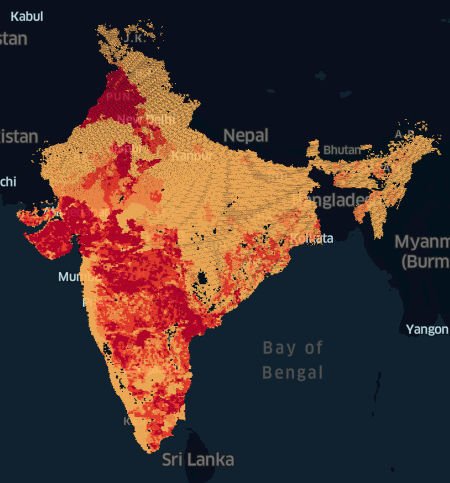

In [14]:

# image showing imports of rubber to chinna
Image(filename = "../../datasets/raw/water_impact_cotton_india.png")

## Retrive and calculate water impact for all sourcing records:



In [31]:
%%time
## query for getting all the sourcing record materials. Here we should include the client filters
# so we end up working just with the minimum amount of data 
sql = """SELECT sl."materialId", hd."h3tableName", hd."h3columnName", mth."type" FROM sourcing_records sr 
LEFT JOIN sourcing_location sl on sr."sourcingLocationId"=sl.id 
LEFT JOIN material_to_h3 mth on sl."materialId" =mth."materialId" 
LEFT JOIN h3_data hd on hd.id = mth."h3DataId" 
-- where sl."materialId"  = '0d7b1be5-dc86-47b8-ba3a-25190a275011' -- add clause dependeding on client filters
GROUP BY sl."materialId", hd."h3tableName", hd."h3columnName", mth."type"
"""

conn = postgres_thread_pool.getconn()
cursor = conn.cursor()
cursor.execute(sql)
#fetch data
response = cursor.fetchall()

#get unique list of materials for iteration
unique_materials = list(set([el[0] for el in response]))
unique_materials

impact_material = []
for material in unique_materials:
    #print('material', material)
    #get harvest area table:
    ha_table = [el[1] for el in response if el[0]==material and el[3]=='harvest'][0]
    ha_column = [el[2] for el in response if el[0]==material and el[3]=='harvest'][0]
    
    #get production table:
    prod_table = [el[1] for el in response if el[0]==material and el[3]=='producer'][0]
    prod_column = [el[2] for el in response if el[0]==material and el[3]=='producer'][0]
    
    # query for each material the h3 data associated with them and perform the imapct calculation
    # this response would need to be then aggregated for all the sourcing records selected by the client
    sql = f"""SELECT  t1.k, (t1.v/sum(t2.ha) over())*t2.ha*t2.wr as waterimpact from
        (SELECT sum(sr.tonnage) as v, h3_uncompact(gr."h3Compact"::h3index[],6) as k FROM sourcing_records sr
        LEFT JOIN sourcing_location sl on sr."sourcingLocationId"=sl.id
        LEFT JOIN geo_region gr on gr.id=sl."geoRegionId" 
        WHERE sl."materialId"='{material}'--add more where clauses depending on selected client filters
        GROUP BY gr."h3Compact" ) t1
    INNER JOIN 
        (SELECT prodtable.h3index as k, indtable."wfBltotMmyr" * 0.001 / sum(prodtable."{prod_column}") over() as wr,
        hatable."{ha_column}"  as ha
        FROM {prod_table} prodtable
        INNER JOIN h3_grid_wf_global indtable on indtable.h3index = prodtable.h3index
        INNER JOIN {ha_table} hatable on hatable.h3index =prodtable.h3index 
        where prodtable."{prod_column}" is not null and indtable."wfBltotMmyr" is not null 
        and hatable."{ha_column}"  is not null) t2
    ON t1.k=t2.k
    """
    #print(sql)
    print('Requesting data...')
    cursor.execute(sql)
    response2 = cursor.fetchall()
    impact_material.append(response2)
    print('Data retrieved!')
    

print('Done!')

Requesting data...
Data retrieved!
Requesting data...
Data retrieved!
Requesting data...
Data retrieved!
Requesting data...
Data retrieved!
Requesting data...
Data retrieved!
Requesting data...
Data retrieved!
Done!
CPU times: user 502 ms, sys: 41.5 ms, total: 543 ms
Wall time: 25.1 s


In [32]:
# export response
#concatenate all retrieving elements on a single array
arr = []
for i in range(0, len(impact_material)):
    arr =  arr+impact_material[i]

In [33]:
len(arr)

794811

In [34]:
unique_k = list(set([el[0] for el in arr]))

In [35]:
len(unique_k)

450587

In [36]:
clean_response = []
for el in tqdm(unique_k):
    value = sum([row[1] for row in arr if row[0]==el and row[1] != None])
    clean_response.append({
        'hexId':el,
        'value': value*1000000000
    })
    

  0%|          | 0/450587 [00:00<?, ?it/s]

In [37]:
# export json and explore in keppler
with open('./distribited_impact_all_sourcing_records.json', 'w') as f:
    json.dump(clean_response, f)

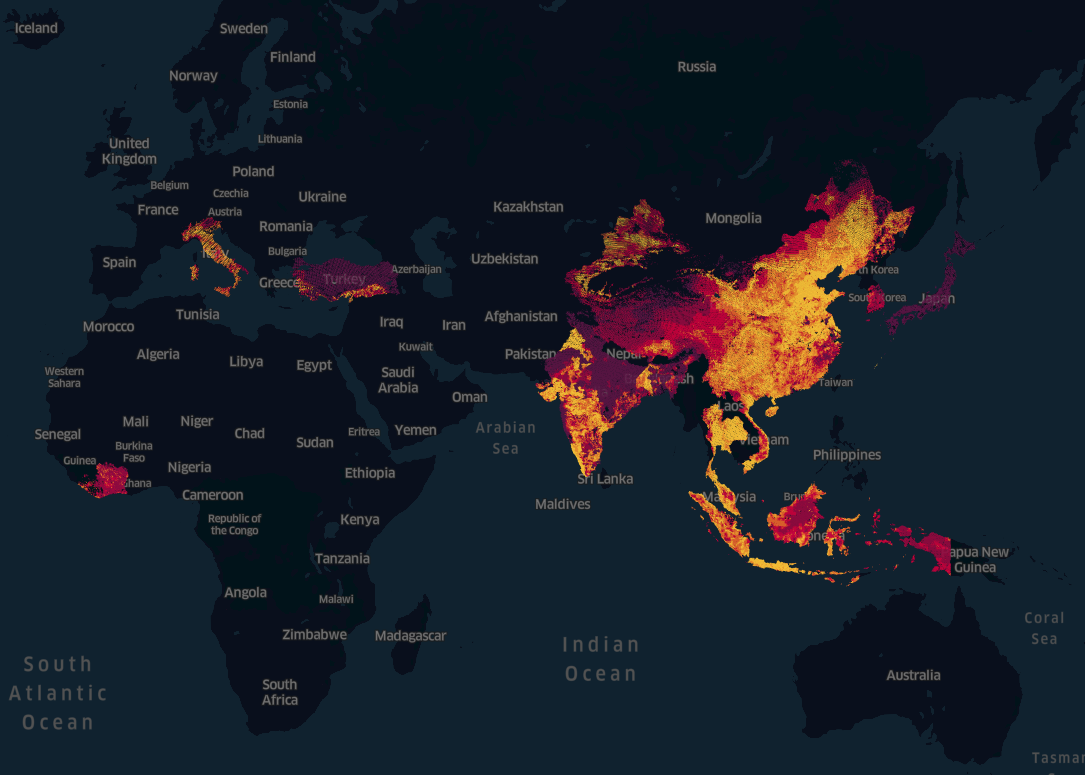

In [38]:
Image(filename = "../../datasets/raw/water_impact_all_sourcing_regions.png")
